In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from reckernel import RecKernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Kuramoto data generation and kernel test

In [2]:
L    = 6
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

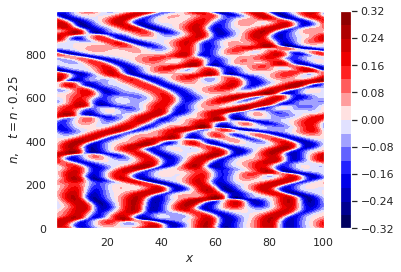

In [3]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [4]:
def gaussian_data(n_input, input_len_max, input_dim, fix_seed=False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

# Arcsin kernel and RC

In [13]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1
# variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection='gaussian', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_rc_asin[j, i, k] = loss(K_hat,K)

20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.04it/s]
20it [00:19,  1.04it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.04it/s]
20it [00:20,  1.01s/it]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.03it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.04it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]
20it [00:19,  1.05it/s]


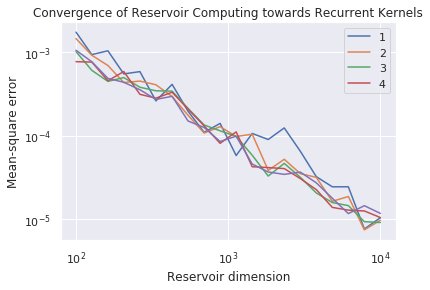

In [15]:
# Plots
ncurves = 5
asin11 = error_rc_asin
nres11 = np.logspace(2, 4, num=20, dtype=int)
len11 = np.arange(start=1, stop=5, step=1)
plt.loglog(nres11, torch.mean(asin11, axis=2)[:ncurves, :].T)
plt.legend(len11[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [ ]:
np.save('out/200521_conv_rc_asin_len1to10_nres1e2to1e4_in1res1', error_rc_asin)

# Arcsin kernel and SRC

In [21]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1  # variance of reservoir

n_input = 50 # number of time series
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection='structured', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_src_asin[j, i, k] = loss(K_hat,K)

15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]


In [22]:
np.save('out/200521_conv_src_asin_len1to10_nres2p8to2p22_in1res1', error_src_asin)

# RBF kernel and RC

In [11]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_rbf = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='cos_rbf', random_projection='gaussian', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_rc_rbf[j, i, k] = loss(K_hat,K)

18it [00:57,  3.19s/it]


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.76 GiB total capacity; 8.57 GiB already allocated; 104.19 MiB free; 9.80 GiB reserved in total by PyTorch)

In [13]:
np.save('out/200521_conv_rc_rbf_len1to10_nres1e2to1e4_in1res1', error_rc_rbf)

# RBF kernel and SRC

In [46]:
n_rep = 4
input_len_range = np.arange(start=1, stop=10, step=1)
first_pow = 8
last_pow = 20  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_rbf = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 0.1  # variance of input
res_scale = 4  # variance of reservoir

n_input = 50 # number of time series
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='cos_rbf', random_projection='structured', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), 
                                  initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_src_rbf[j, i, k] = loss(K_hat,K)

13it [00:09,  1.32it/s]
13it [00:09,  1.33it/s]
13it [00:09,  1.33it/s]
13it [00:09,  1.33it/s]


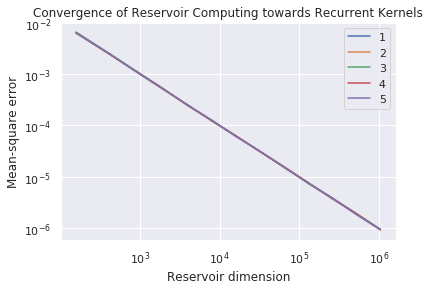

In [47]:
# Plots
ncurves = 5
plt.loglog(n_res_range, torch.mean(error_src_rbf, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [24]:
np.save('out/200521_conv_src_rbf_len1to10_nres2p8to2p22_in1res1', error_src_rbf)

# Arccos kernel and RC

In [11]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_acos = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='heaviside', random_projection='gaussian', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_rc_acos[j, i, k] = loss(K_hat,K)

18it [00:57,  3.19s/it]


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.76 GiB total capacity; 8.57 GiB already allocated; 104.19 MiB free; 9.80 GiB reserved in total by PyTorch)

In [13]:
np.save('out/200521_conv_rc_acos_len1to10_nres1e2to1e4_in1res1', error_rc_acos)

# Arccos kernel and SRC

In [17]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_acos = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1  # variance of reservoir

n_input = 50 # number of time series
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='heaviside', random_projection='structured', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_src_acos[j, i, k] = loss(K_hat,K)

15it [00:20,  1.38s/it]
15it [00:20,  1.39s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.38s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.37s/it]
15it [00:20,  1.38s/it]


In [18]:
np.save('out/200521_conv_src_acos_len1to10_nres2p8to2p22_in1res1', error_src_acos)

# Arcsin / sign kernel and RC

In [11]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin2 = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='sign', random_projection='gaussian', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_rc_asin2[j, i, k] = loss(K_hat,K)

18it [00:57,  3.19s/it]


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.76 GiB total capacity; 8.57 GiB already allocated; 104.19 MiB free; 9.80 GiB reserved in total by PyTorch)

In [13]:
np.save('out/200521_conv_rc_asin2_len1to10_nres1e2to1e4_in1res1', error_rc_asin2)

# Arcsin / sign kernel and SRC

In [19]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin2 = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1  # variance of reservoir

n_input = 50 # number of time series
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='sign', random_projection='structured', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_src_asin2[j, i, k] = loss(K_hat,K)

15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.29s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.29s/it]
15it [00:19,  1.29s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.29s/it]
15it [00:19,  1.29s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.31s/it]
15it [00:19,  1.30s/it]


In [20]:
np.save('out/200521_conv_src_asin2_len1to10_nres2p8to2p22_in1res1', error_src_asin2)

# Linear kernel and RC

In [9]:
n_rep = 40
input_len_range = np.arange(start=1, stop=10, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_lin = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 0.25

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='linear', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='linear', random_projection='gaussian', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(123)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_rc_lin[j, i, k] = loss(K_hat,K)

20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.07it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]
20it [00:18,  1.08it/s]


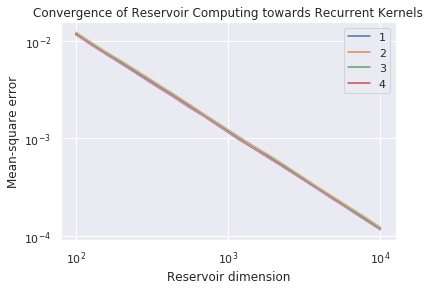

In [10]:
# Plots
ncurves = 10
asin11 = error_rc_lin
nres11 = np.logspace(2, 4, num=20, dtype=int)
len11 = np.arange(start=1, stop=5, step=1)
plt.loglog(nres11, torch.mean(asin11, axis=2)[:ncurves, :].T)
plt.legend(len11[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [11]:
np.save('out/200521_conv_rc_lin_len1to10_nres1e2to1e4_in1res025', error_rc_lin)

# Linear kernel and SRC

In [25]:
n_rep = 40
input_len_range = np.arange(start=1, stop=20, step=1)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_lin = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
input_scale = 1  # variance of input
res_scale = 1  # variance of reservoir

n_input = 50 # number of time series
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='linear', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

for k in range(n_rep):
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='linear', random_projection='structured', seed=k)
        for j, input_len in (enumerate(input_len_range)):
            torch.manual_seed(1000*k+j)
            input_data = gaussian_data(n_input, input_len, input_dim)

            K = RK.forward(input_data)
            X_final = torch.zeros((n_input,n_res)).to(device)

            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
                X_final[n_in,:] = X[-1,:]

            K_hat = torch.matmul(X_final,X_final.t())
            error_src_lin[j, i, k] = loss(K_hat,K)

15it [01:10,  4.69s/it]
15it [01:10,  4.67s/it]
15it [01:10,  4.68s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.72s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.72s/it]
15it [01:10,  4.71s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.68s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.68s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.69s/it]
15it [01:10,  4.71s/it]
15it [01:10,  4.70s/it]
15it [01:10,  4.71s/it]


In [26]:
np.save('out/200522_conv_src_lin_len1to10_nres2p8to2p22_in1res1', error_src_lin)